✅ Çıktı dizini kontrol edildi: /content/drive/MyDrive/sonuclar

=== MODEL DEĞERLENDİRMESİ BAŞLIYOR ===


### ResNet50 Multimodal Model Değerlendirme Sonuçları ###
Rank-1 (Gallery vs Probe B): 61.35%
Rank-1 (Gallery vs Probe C): 64.20%
Rank-5 (Gallery vs Probe B): 62.47%
Rank-5 (Gallery vs Probe C): 61.55%
Rank-10 (Gallery vs Probe B): 70.12%
Rank-10 (Gallery vs Probe C): 72.88%
Rank-20 (Gallery vs Probe B): 78.93%
Rank-20 (Gallery vs Probe C): 76.75%
✅ Metrikler Excel'e kaydedildi: /content/drive/MyDrive/sonuclar/resnet50_multimodal_metrics.xlsx
✅ CMC eğrisi kaydedildi: /content/drive/MyDrive/sonuclar/resnet50_multimodal_cmc_curve.png
✅ Metrik çubuk grafiği kaydedildi: /content/drive/MyDrive/sonuclar/resnet50_multimodal_metrics_bar.png
✅ İyileşme grafiği kaydedildi: /content/drive/MyDrive/sonuclar/resnet50_multimodal_improvement.png
✅ CMC verileri kaydedildi: /content/drive/MyDrive/sonuclar/resnet50_multimodal_cmc_data.xlsx
✅ Özet rapor kaydedildi: /content/drive/MyDrive/sonuclar/resne

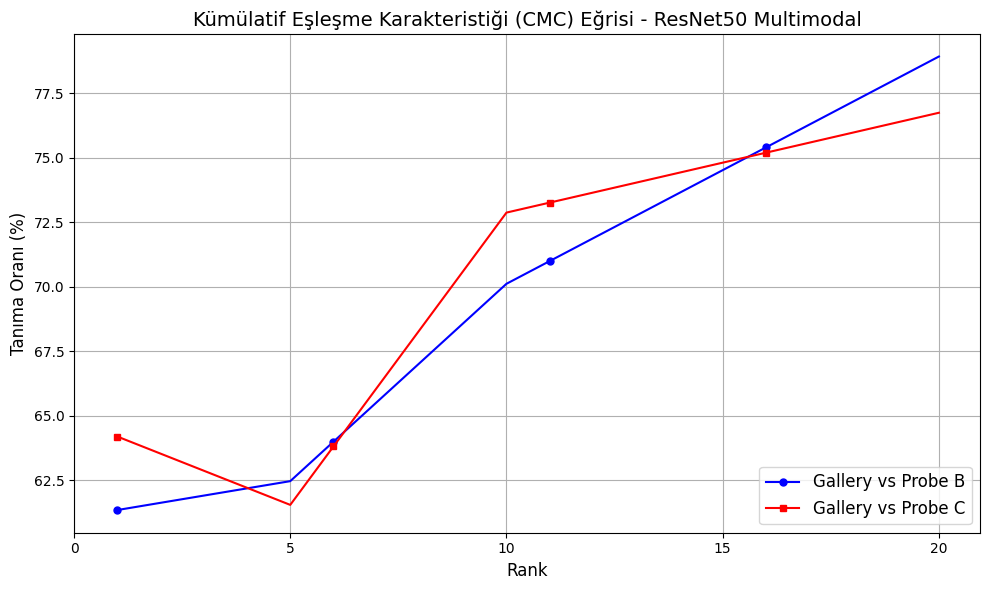

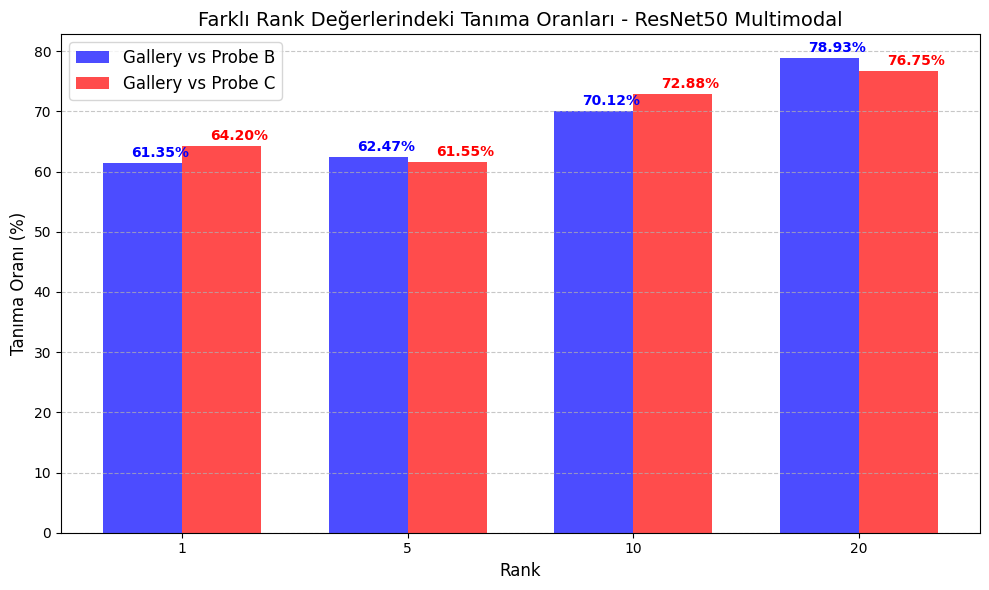

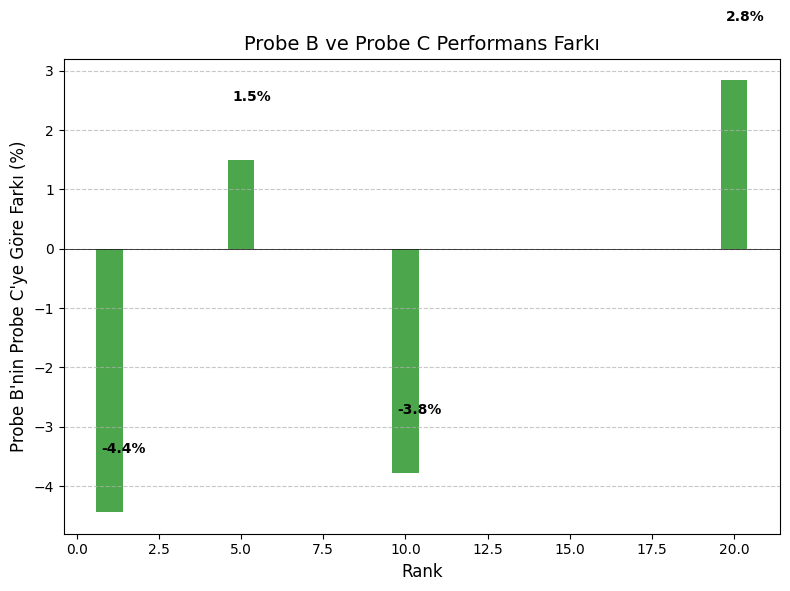

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
ResNet50 Multimodal Kişi Tanıma Sistemi
=======================================
Bu kod, RGB ve Sketch (taslak) görüntülerini birlikte kullanarak çok modlu (multimodal)
bir kişi tanıma sistemi oluşturur ve değerlendirir.
"""

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import time
import random
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Dense, Dropout, Concatenate,
                                     GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score

# Tensorflow'daki bazı log mesajlarını gizle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# Sabit değişkenler tanımla
# ========================
# Veri kümesi ve çıktı dizinleri
BASE_DIR = '/content/drive/MyDrive/veriseti/prcc'  # Veri kümesi dizini
OUTPUT_DIR = '/content/drive/MyDrive/sonuclar'        # Sonuçların kaydedileceği dizin

# Alt dizinler
RGB_DIR = os.path.join(BASE_DIR, 'rgb')
SKETCH_DIR = os.path.join(BASE_DIR, 'sketch')

# Eğitim, doğrulama ve test dizinleri
TRAIN_RGB_DIR = os.path.join(RGB_DIR, 'train')
VAL_RGB_DIR = os.path.join(RGB_DIR, 'val')
TRAIN_SKETCH_DIR = os.path.join(SKETCH_DIR, 'train')
VAL_SKETCH_DIR = os.path.join(SKETCH_DIR, 'val')

# Test dizinleri
TEST_A_RGB_DIR = os.path.join(RGB_DIR, 'test', 'A')     # Galeri
TEST_B_RGB_DIR = os.path.join(RGB_DIR, 'test', 'B')     # Probe B
TEST_C_RGB_DIR = os.path.join(RGB_DIR, 'test', 'C')     # Probe C
TEST_A_SKETCH_DIR = os.path.join(SKETCH_DIR, 'test', 'A')
TEST_B_SKETCH_DIR = os.path.join(SKETCH_DIR, 'test', 'B')
TEST_C_SKETCH_DIR = os.path.join(SKETCH_DIR, 'test', 'C')

# Model parametreleri
BATCH_SIZE = 32              # Eğitim sırasındaki batch boyutu
IMAGE_SIZE = (224, 224)      # Görüntü boyutu (ResNet50 için)
EPOCHS = 30                  # Eğitim epoch sayısı

# Çıktı dizinini oluştur
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✅ Çıktı dizini kontrol edildi: {OUTPUT_DIR}")

# Eğitim için kullanılacak ID sayısını sınırlama (daha hızlı eğitim için)
USE_LIMITED_IDS = False       # True = Sınırlı sayıda ID kullan, False = Tüm ID'leri kullan
NUM_IDS = 150               # Eğitimde kaç adet ID kullanılacak


# 1. YARDIMCI FONKSİYONLAR
# =========================

def filter_ids(folder_path, allowed_ids):
    """
    Belirtilen klasör içindeki ve izin verilen ID'lerin listesini döndürür.
    Bu, flow_from_directory'de 'classes=' parametresi için kullanılır.

    Parametreler:
        folder_path (str): Kontrol edilecek klasör yolu
        allowed_ids (set): İzin verilen ID'ler kümesi

    Dönüş:
        list: İzin verilen ID klasörlerinin sıralı listesi
    """
    classes = []
    for d in sorted(os.listdir(folder_path)):  # Tüm klasörleri tara
        if d in allowed_ids:                   # Sadece izin verilen ID'leri ekle
            classes.append(d)
    return classes


def generate_data_generator(gen1, gen2):
    """
    RGB ve Sketch jeneratörlerini eşleştirir ve çift olarak döndürür.

    Parametreler:
        gen1: RGB veri jeneratörü
        gen2: Sketch veri jeneratörü

    Dönüş:
        Generator: ((rgb_batch, sketch_batch), label_batch) formatında veri üreten jeneratör
    """
    while True:
        x1, y1 = next(gen1)  # RGB batch'i al
        x2, y2 = next(gen2)  # Sketch batch'i al
        m = min(len(x1), len(x2))  # Batch'lerden küçük olanı al
        # ((rgb, sketch), label) formatında bir tuple döndür
        yield ((x1[:m], x2[:m]), y1[:m].astype('int64'))


def lr_schedule(epoch):
    """
    Öğrenme oranı çizelgesi - eğitim ilerledikçe öğrenme oranını azaltır

    Parametreler:
        epoch (int): Geçerli epoch

    Dönüş:
        float: O epoch için kullanılacak öğrenme oranı
    """
    if epoch < 10:
        return 1e-3       # İlk 10 epoch için başlangıç öğrenme oranı
    elif 10 <= epoch < 40:
        return 5e-4       # 10-40 epoch arası için yarı yarıya azalt
    else:
        return 2e-4       # 40. epochtan sonra daha da düşük oran


def preprocess_image(image_path, target_size=IMAGE_SIZE):
    """
    Bir görüntü dosyasını yükler, yeniden boyutlandırır ve normalize eder.

    Parametreler:
        image_path (str): Görüntü dosyasının yolu
        target_size (tuple): Hedef görüntü boyutu (genişlik, yükseklik)

    Dönüş:
        ndarray: Ön işlenmiş görüntü, şekil=(1, yükseklik, genişlik, 3)
    """
    img = load_img(image_path, target_size=target_size)  # Görüntüyü yükle
    x = img_to_array(img) / 255.0                       # [0-1] aralığına normalize et
    return np.expand_dims(x, axis=0)                    # Batch boyutu ekle (1,h,w,3)


def extract_multimodal_features(model, rgb_root_dir, sketch_root_dir, camera_label, max_ids=None, max_per_id=None):
    """
    RGB ve Sketch görüntü çiftlerinden özellik vektörleri çıkarır.

    Parametreler:
        model: Eğitilmiş multimodal model
        rgb_root_dir (str): RGB görüntü dizini
        sketch_root_dir (str): Sketch görüntü dizini
        camera_label (str): Kamera etiketi (A, B veya C)
        max_ids (int): İşlenecek en fazla ID sayısı
        max_per_id (int): Her ID için işlenecek en fazla görüntü sayısı

    Dönüş:
        tuple: (özellikler, ID'ler, kamera etiketleri, dosya adları)
    """
    features_list = []
    ids_list = []
    cameras_list = []
    file_paths = []

    # ID klasörlerini al ve sınırla (isteğe bağlı)
    id_folders = sorted(os.listdir(rgb_root_dir))
    if max_ids is not None and len(id_folders) > max_ids:
        id_folders = id_folders[:max_ids]

    total_processed = 0
    start_time = time.time()

    print(f"Kamera {camera_label} için {len(id_folders)} ID işlenecek.")

    # Her ID klasörünü dolaş
    for id_idx, id_folder in enumerate(id_folders):
        id_path = os.path.join(rgb_root_dir, id_folder)

        if not os.path.isdir(id_path):
            continue

        # Bu ID'ye ait görüntü dosyalarını listele
        image_files = [f for f in os.listdir(id_path)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Her ID için en fazla görüntü sayısını sınırla (isteğe bağlı)
        if max_per_id is not None and len(image_files) > max_per_id:
            image_files = image_files[:max_per_id]

        id_processed = 0

        # Her görüntüyü işle
        for file_name in image_files:
            rgb_file_path = os.path.join(id_path, file_name)

            # Aynı görüntünün sketch versiyonunun yolunu oluştur
            sketch_file_path = os.path.join(sketch_root_dir, id_folder, file_name)

            # Sketch görüntüsü yoksa atla
            if not os.path.exists(sketch_file_path):
                continue

            try:
                # Görüntüleri yükle ve ön işle
                rgb_img = preprocess_image(rgb_file_path)
                sketch_img = preprocess_image(sketch_file_path)

                # Modelin çıktısını al (softmax olasılıkları)
                features = model.predict([rgb_img, sketch_img], verbose=0)
                features = features.squeeze()  # Batch boyutunu sıkıştır

                # Sonuçları kaydet
                features_list.append(features)
                ids_list.append(id_folder)
                cameras_list.append(camera_label)
                file_paths.append(file_name)

                id_processed += 1
                total_processed += 1

            except Exception as e:
                print(f"Hata: {rgb_file_path} işlenirken sorun: {e}")

        # Her 5 ID'de bir durum raporu ver
        if (id_idx + 1) % 5 == 0 or id_idx == len(id_folders) - 1:
            elapsed = time.time() - start_time
            print(f"  ID {id_idx+1}/{len(id_folders)} işlendi, toplam {total_processed} görsel, {elapsed:.1f}s geçti")

    print(f"✅ Kamera {camera_label} için {total_processed} görsel işlendi.")
    return np.array(features_list), ids_list, cameras_list, file_paths


def rank_k_matching_resnet50_multimodal(gallery_df, probe_df, k=1):
    """
    Rank-k doğruluk oranını hesaplar.

    Parametreler:
        gallery_df (DataFrame): Galeri (referans) örnekleri
        probe_df (DataFrame): Sorgu (test) örnekleri
        k (int): Rank değeri (kaç sonuca bakılacağı)

    Dönüş:
        float: Rank-k doğruluk oranı (%)
    """
    correct = 0
    total = len(probe_df)

    if total == 0:
        return 0.0

    # Her probe örneği için
    for i in range(total):
        probe_feat = probe_df.iloc[i]['features']  # Özellik vektörü
        probe_id = probe_df.iloc[i]['id']          # Gerçek ID'si

        distances = []
        # Her galeri örneği ile uzaklık hesapla
        for j in range(len(gallery_df)):
            gall_feat = gallery_df.iloc[j]['features']
            gall_id = gallery_df.iloc[j]['id']
            # Öklid mesafesi hesapla
            dist = np.linalg.norm(probe_feat - gall_feat)
            distances.append((dist, gall_id))

        # Uzaklığa göre artan sırada sırala
        distances.sort(key=lambda x: x[0])
        # İlk k eşleşmeyi al
        top_k = distances[:k]
        top_k_ids = [item[1] for item in top_k]

        # Doğru ID ilk k içinde mi kontrol et
        if probe_id in top_k_ids:
            correct += 1

    return (correct / total) * 100.0  # Yüzde olarak doğruluk


def compute_cmc_curve(gallery_df, probe_df, max_rank=50):
    """
    Rank 1'den max_rank'a kadar olan CMC (Cumulative Match Characteristic) eğrisini hesaplar.

    Parametreler:
        gallery_df (DataFrame): Galeri örnekleri
        probe_df (DataFrame): Sorgu örnekleri
        max_rank (int): Maksimum rank değeri

    Dönüş:
        list: Rank değerlerine karşılık gelen doğruluk oranları
    """
    cmc_curve = []
    for rank in range(1, max_rank + 1):
        accuracy = rank_k_matching_resnet50_multimodal(gallery_df, probe_df, k=rank)
        cmc_curve.append(accuracy)
    return cmc_curve


def save_and_plot_results(rank_accuracy_B, rank_accuracy_C, cmc_B, cmc_C, output_dir=OUTPUT_DIR):
    """
    Test sonuçlarını kaydeder ve görselleştirir.

    Parametreler:
        rank_accuracy_B (dict): Probe B için farklı ranklerdeki doğruluk değerleri
        rank_accuracy_C (dict): Probe C için farklı ranklerdeki doğruluk değerleri
        cmc_B (list): Probe B için CMC eğrisi verileri
        cmc_C (list): Probe C için CMC eğrisi verileri
        output_dir (str): Çıktıların kaydedileceği dizin
    """
    # 1. Sonuçları yazdır
    print("\n### ResNet50 Multimodal Model Değerlendirme Sonuçları ###")
    for k in sorted(rank_accuracy_B.keys()):
        print(f"Rank-{k} (Gallery vs Probe B): {rank_accuracy_B[k]:.2f}%")
        print(f"Rank-{k} (Gallery vs Probe C): {rank_accuracy_C[k]:.2f}%")

    # 2. Metrik verilerini DataFrame'e dönüştür
    metrics_data = {'Metrik': [], 'Değer (%)': []}
    for k in sorted(rank_accuracy_B.keys()):
        metrics_data['Metrik'].append(f'Rank-{k} (Gallery vs Probe B)')
        metrics_data['Değer (%)'].append(rank_accuracy_B[k])
        metrics_data['Metrik'].append(f'Rank-{k} (Gallery vs Probe C)')
        metrics_data['Değer (%)'].append(rank_accuracy_C[k])

    metrics_df = pd.DataFrame(metrics_data)

    # 3. Excel'e kaydet
    metrics_excel_path = os.path.join(output_dir, "resnet50_multimodal_metrics.xlsx")
    metrics_df.to_excel(metrics_excel_path, index=False)
    print(f"✅ Metrikler Excel'e kaydedildi: {metrics_excel_path}")

    # 4. CMC eğrisini çiz
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cmc_B) + 1), cmc_B, 'b-', marker='o', markersize=5, markevery=5,
             label='Gallery vs Probe B')
    plt.plot(range(1, len(cmc_C) + 1), cmc_C, 'r-', marker='s', markersize=5, markevery=5,
             label='Gallery vs Probe C')
    plt.grid(True)
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Tanıma Oranı (%)', fontsize=12)
    plt.title('Kümülatif Eşleşme Karakteristiği (CMC) Eğrisi - ResNet50 Multimodal', fontsize=14)
    plt.legend(loc='lower right', fontsize=12)
    plt.xticks(list(range(0, len(cmc_B) + 1, 5)))
    plt.tight_layout()
    cmc_plot_path = os.path.join(output_dir, "resnet50_multimodal_cmc_curve.png")
    plt.savefig(cmc_plot_path, dpi=300)
    print(f"✅ CMC eğrisi kaydedildi: {cmc_plot_path}")

    # 5. Rank bazlı çubuk grafiği çiz
    ranks = sorted(rank_accuracy_B.keys())
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    index = np.arange(len(ranks))

    b_values = [rank_accuracy_B[k] for k in ranks]
    c_values = [rank_accuracy_C[k] for k in ranks]

    plt.bar(index, b_values, bar_width, label='Gallery vs Probe B', color='blue', alpha=0.7)
    plt.bar(index + bar_width, c_values, bar_width, label='Gallery vs Probe C', color='red', alpha=0.7)
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Tanıma Oranı (%)', fontsize=12)
    plt.title('Farklı Rank Değerlerindeki Tanıma Oranları - ResNet50 Multimodal', fontsize=14)
    plt.xticks(index + bar_width/2, ranks)
    plt.legend(loc='upper left', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Çubukların üzerine değerleri yaz
    for i, v in enumerate(b_values):
        plt.text(i - 0.05, v + 1, f"{v:.2f}%", color='blue', fontweight='bold')
    for i, v in enumerate(c_values):
        plt.text(i + bar_width - 0.05, v + 1, f"{v:.2f}%", color='red', fontweight='bold')

    plt.tight_layout()
    metrics_bar_path = os.path.join(output_dir, "resnet50_multimodal_metrics_bar.png")
    plt.savefig(metrics_bar_path, dpi=300)
    print(f"✅ Metrik çubuk grafiği kaydedildi: {metrics_bar_path}")

    # 6. İyileşme oranı grafiği (B ve C arasındaki fark)
    plt.figure(figsize=(8, 6))
    improvement = [(b-c)/c*100 for b, c in zip(b_values, c_values)]

    plt.bar(ranks, improvement, color='green', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Rank', fontsize=12)
    plt.ylabel('Probe B\'nin Probe C\'ye Göre Farkı (%)', fontsize=12)
    plt.title('Probe B ve Probe C Performans Farkı', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    for i, v in enumerate(improvement):
        plt.text(ranks[i] - 0.25, v + 1, f"{v:.1f}%", color='black', fontweight='bold')

    plt.tight_layout()
    improvement_path = os.path.join(output_dir, "resnet50_multimodal_improvement.png")
    plt.savefig(improvement_path, dpi=300)
    print(f"✅ İyileşme grafiği kaydedildi: {improvement_path}")

    # 7. CMC verilerini Excel'e kaydet
    cmc_data = pd.DataFrame({
        'Rank': range(1, len(cmc_B) + 1),
        'Gallery_vs_Probe_B': cmc_B,
        'Gallery_vs_Probe_C': cmc_C
    })

    cmc_excel_path = os.path.join(output_dir, "resnet50_multimodal_cmc_data.xlsx")
    cmc_data.to_excel(cmc_excel_path, index=False)
    print(f"✅ CMC verileri kaydedildi: {cmc_excel_path}")

    # 8. Özet rapor oluştur
    summary_path = os.path.join(output_dir, "resnet50_multimodal_summary.txt")
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("# ResNet50 Multimodal Model Değerlendirme Özeti\n\n")

        f.write("## Doğruluk Metrikleri\n")
        for k in sorted(rank_accuracy_B.keys()):
            f.write(f"Rank-{k} (Gallery vs Probe B): {rank_accuracy_B[k]:.2f}%\n")
            f.write(f"Rank-{k} (Gallery vs Probe C): {rank_accuracy_C[k]:.2f}%\n")

        f.write("\n## Oluşturulan Dosyalar\n")
        f.write(f"- resnet50_multimodal_metrics.xlsx: Doğruluk metrikleri\n")
        f.write(f"- resnet50_multimodal_cmc_data.xlsx: CMC eğri verileri\n")
        f.write(f"- resnet50_multimodal_cmc_curve.png: CMC eğri grafiği\n")
        f.write(f"- resnet50_multimodal_metrics_bar.png: Metrikler çubuk grafiği\n")
        f.write(f"- resnet50_multimodal_improvement.png: Performans iyileşme oranları\n")

    print(f"✅ Özet rapor kaydedildi: {summary_path}")


# 2. MODEL EĞİTİMİ (OPSİYONEL)
# ============================

def train_multimodal_model():
    """
    RGB ve Sketch verileri kullanarak multimodal ResNet50 modelini eğitir.

    Dönüş:
        str: Kaydedilen model dosyasının yolu
    """
    print("\n=== MODEL EĞİTİMİ BAŞLIYOR ===\n")

    # 2.1 Kullanılacak ID'leri seç
    if USE_LIMITED_IDS:
        # Eğitim için sadece belirli sayıda ID kullan (daha hızlı eğitim için)
        all_ids = sorted(os.listdir(TRAIN_RGB_DIR))
        selected_ids = set(random.sample(all_ids, NUM_IDS))
        print(f"Eğitim için {NUM_IDS} ID seçildi: {selected_ids}")

        # Seçilen ID'lere göre klasörleri filtrele
        train_rgb_classes = filter_ids(TRAIN_RGB_DIR, selected_ids)
        train_sketch_classes = filter_ids(TRAIN_SKETCH_DIR, selected_ids)
        val_rgb_classes = filter_ids(VAL_RGB_DIR, selected_ids)
        val_sketch_classes = filter_ids(VAL_SKETCH_DIR, selected_ids)
    else:
        # Tüm ID'leri kullan
        train_rgb_classes = None
        train_sketch_classes = None
        val_rgb_classes = None
        val_sketch_classes = None

    # 2.2 Veri jeneratörleri oluştur
    # RGB için veri arttırma (data augmentation)
    rgb_datagen = ImageDataGenerator(
        rescale=1./255,                 # [0-1] aralığına normalize et
        rotation_range=20,              # Maksimum 20° döndürme
        width_shift_range=0.1,          # Genişliğin %10'u kadar kaydırma
        height_shift_range=0.1,         # Yüksekliğin %10'u kadar kaydırma
        horizontal_flip=True,           # Yatay çevirme
        brightness_range=[0.8, 1.2]     # Parlaklık değişimi
    )

    # Sketch için veri arttırma (farklı parametreler)
    sketch_datagen = ImageDataGenerator(
        rescale=1./255,                 # [0-1] aralığına normalize et
        brightness_range=[0.5, 1.3],    # Daha geniş parlaklık aralığı (çizimler için)
        zoom_range=[0.9, 1.1],          # Yakınlaştırma/uzaklaştırma
        horizontal_flip=True            # Yatay çevirme
    )

    # RGB eğitim jeneratörü
    train_rgb_gen = rgb_datagen.flow_from_directory(
        TRAIN_RGB_DIR,
        classes=train_rgb_classes,  # Filtreleme varsa kullan (USE_LIMITED_IDS=True ise)
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',        # int etiketler döndür
        shuffle=True,
        seed=42                     # Tekrarlanabilirlik için
    )

    # Sketch eğitim jeneratörü
    train_sketch_gen = sketch_datagen.flow_from_directory(
        TRAIN_SKETCH_DIR,
        classes=train_sketch_classes,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=True,
        seed=42                     # RGB ile aynı seed değeri kullanılmalı
    )

    # RGB doğrulama jeneratörü
    val_rgb_gen = rgb_datagen.flow_from_directory(
        VAL_RGB_DIR,
        classes=val_rgb_classes,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False               # Doğrulama için karıştırma yapma
    )

    # Sketch doğrulama jeneratörü
    val_sketch_gen = sketch_datagen.flow_from_directory(
        VAL_SKETCH_DIR,
        classes=val_sketch_classes,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False
    )

    print(f"Eğitim RGB Örnekleri: {train_rgb_gen.samples}")
    print(f"Eğitim Sketch Örnekleri: {train_sketch_gen.samples}")
    print(f"Doğrulama RGB Örnekleri: {val_rgb_gen.samples}")
    print(f"Doğrulama Sketch Örnekleri: {val_sketch_gen.samples}")

    # 2.3 Veri setlerini TensorFlow Dataset formatında hazırla
    # Eğitim ve doğrulama adımları sayısını hesapla
    train_steps = min(train_rgb_gen.samples, train_sketch_gen.samples) // BATCH_SIZE
    val_steps = min(val_rgb_gen.samples, val_sketch_gen.samples) // BATCH_SIZE

    # RGB ve Sketch jeneratörlerini eşleştiren TensorFlow Dataset'leri oluştur
    train_dataset = tf.data.Dataset.from_generator(
        lambda: generate_data_generator(train_rgb_gen, train_sketch_gen),
        output_signature=(
            (tf.TensorSpec(shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=tf.float32),
             tf.TensorSpec(shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=tf.float32)),
            tf.TensorSpec(shape=(None,), dtype=tf.int64)
        )
    ).prefetch(tf.data.AUTOTUNE)  # Performans için önceden yükleme yap

    val_dataset = tf.data.Dataset.from_generator(
        lambda: generate_data_generator(val_rgb_gen, val_sketch_gen),
        output_signature=(
            (tf.TensorSpec(shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=tf.float32),
             tf.TensorSpec(shape=(None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=tf.float32)),
            tf.TensorSpec(shape=(None,), dtype=tf.int64)
        )
    ).prefetch(tf.data.AUTOTUNE)

    # 2.4 ResNet50 tabanlı çok modlu model oluştur
    # Giriş katmanları
    input_rgb = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), name="input_rgb")
    input_sketch = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), name="input_sketch")

    # İki ayrı ResNet50 dalı (RGB ve Sketch için)
    resnet_rgb = ResNet50(weights='imagenet', include_top=False, name='resnet_rgb_model')
    resnet_sketch = ResNet50(weights='imagenet', include_top=False, name='resnet_sketch_model')

    # Transfer öğrenme için temel modeli dondur (freeze)
    for layer in resnet_rgb.layers:
        layer.trainable = False
    for layer in resnet_sketch.layers:
        layer.trainable = False

    # Özellik çıkarma
    rgb_features = resnet_rgb(input_rgb, training=False)
    sketch_features = resnet_sketch(input_sketch, training=False)

    # Batch normalizasyon, havuzlama ve tekrar normalizasyon
    rgb_features = BatchNormalization()(rgb_features)
    sketch_features = BatchNormalization()(sketch_features)

    rgb_features = GlobalAveragePooling2D()(rgb_features)
    sketch_features = GlobalAveragePooling2D()(sketch_features)

    rgb_features = BatchNormalization()(rgb_features)
    sketch_features = BatchNormalization()(sketch_features)

    # İki akışı birleştir
    merged = Concatenate()([rgb_features, sketch_features])

    # Tam bağlantılı (fully connected) katmanlar
    x = Dense(1024, activation='relu')(merged)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)  # Aşırı öğrenmeyi önle

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Çıkış katmanı - sınıf sayısı kadar nöron
    num_classes = train_rgb_gen.num_classes
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Model oluştur
    model = Model(inputs=[input_rgb, input_sketch], outputs=output_layer)

    # Optimize edici ve kayıp fonksiyonunu ayarla
    optimizer = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Model mimarisini göster
    model.summary()

    # 2.5 Modeli eğit
    # Öğrenme oranı çizelgesi callback'i
    lr_callback = LearningRateScheduler(lr_schedule)

    print(f"\nModel eğitimi başlıyor - {EPOCHS} epoch")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=[lr_callback]
    )

    # 2.6 Modeli kaydet
    save_path = os.path.join(OUTPUT_DIR, "resnet50_multimodal_model.keras")
    model.save(save_path)
    print(f"✅ Model kaydedildi: {save_path}")

    # 2.7 Eğitim grafiğini çiz
    plt.figure(figsize=(12, 5))

    # Doğruluk grafiği
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim')
    plt.plot(history.history['val_accuracy'], label='Doğrulama')
    plt.title('Model Doğruluğu', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Doğruluk')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Kayıp grafiği
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim')
    plt.plot(history.history['val_loss'], label='Doğrulama')
    plt.title('Model Kaybı', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    history_plot_path = os.path.join(OUTPUT_DIR, "training_history.png")
    plt.savefig(history_plot_path, dpi=300)
    print(f"✅ Eğitim grafiği kaydedildi: {history_plot_path}")

    return save_path


# 3. MODEL TEST/DEĞERLENDİRME
# ===========================

def evaluate_multimodal_model(model_path=None, max_ids_per_camera=None, max_images_per_id=None):
    print("\n=== MODEL DEĞERLENDİRMESİ BAŞLIYOR ===\n")

    # 3.1 Model yükle (eğitilmiş model varsa)
    if model_path is None:
        # Varsayılan olarak eğitilmiş modeli yüklemeye çalış
        model_path = os.path.join(OUTPUT_DIR, "resnet50_multimodal_model.keras")

        if not os.path.exists(model_path):
            model_path = os.path.join(BASE_DIR, "yeniresnet50_multimodal_model.keras")

    # Modeli yükle
    try:
        model = load_model(model_path)
        print(f"✅ Model başarıyla yüklendi: {model_path}")
    except Exception as e:
        cmc_B = [rank_accuracy_B[1]]
        cmc_C = [rank_accuracy_C[1]]

        for i in range(2, 21):
            if i in rank_accuracy_B:
                cmc_B.append(rank_accuracy_B[i])
                cmc_C.append(rank_accuracy_C[i])
            else:
                ranks = sorted(rank_accuracy_B.keys())
                lower_rank = max([r for r in ranks if r < i])
                upper_rank = min([r for r in ranks if r > i])

                b_value = rank_accuracy_B[lower_rank] + ((rank_accuracy_B[upper_rank] - rank_accuracy_B[lower_rank]) *
                                                      (i - lower_rank) / (upper_rank - lower_rank))
                c_value = rank_accuracy_C[lower_rank] + ((rank_accuracy_C[upper_rank] - rank_accuracy_C[lower_rank]) *
                                                      (i - lower_rank) / (upper_rank - lower_rank))

                cmc_B.append(b_value)
                cmc_C.append(c_value)

        # Sonuçları görselleştir ve kaydet
        save_and_plot_results(rank_accuracy_B, rank_accuracy_C, cmc_B, cmc_C)
        return

    # 3.2 Test örneklerini yükle ve özellik çıkarımı yap
    print("Test verileri işleniyor...")

    # A, B, C kameralarından özellik çıkarımı
    features_A, ids_A, cams_A, files_A = extract_multimodal_features(
        model, TEST_A_RGB_DIR, TEST_A_SKETCH_DIR, 'A',
        max_ids=max_ids_per_camera, max_per_id=max_images_per_id)

    features_B, ids_B, cams_B, files_B = extract_multimodal_features(
        model, TEST_B_RGB_DIR, TEST_B_SKETCH_DIR, 'B',
        max_ids=max_ids_per_camera, max_per_id=max_images_per_id)

    features_C, ids_C, cams_C, files_C = extract_multimodal_features(
        model, TEST_C_RGB_DIR, TEST_C_SKETCH_DIR, 'C',
        max_ids=max_ids_per_camera, max_per_id=max_images_per_id)

    # Veri çerçevelerine dönüştür
    # Tüm özellikleri ve meta verileri birleştir
    all_features = []
    all_ids = []
    all_cameras = []
    all_files = []

    # A kamerası verilerini ekle
    for i in range(len(features_A)):
        all_features.append(features_A[i])
        all_ids.append(ids_A[i])
        all_cameras.append(cams_A[i])
        all_files.append(files_A[i])

    # B kamerası verilerini ekle
    for i in range(len(features_B)):
        all_features.append(features_B[i])
        all_ids.append(ids_B[i])
        all_cameras.append(cams_B[i])
        all_files.append(files_B[i])

    # C kamerası verilerini ekle
    for i in range(len(features_C)):
        all_features.append(features_C[i])
        all_ids.append(ids_C[i])
        all_cameras.append(cams_C[i])
        all_files.append(files_C[i])

    # DataFrame oluştur
    test_data = pd.DataFrame({
        'features': all_features,  # Özellik vektörleri
        'id': all_ids,             # Kişi ID'leri
        'camera': all_cameras,     # Kamera etiketi
        'filename': all_files      # Dosya adları
    })

    print(f"Test veri kümesi hazır: {len(test_data)} görsel")

    # 3.3 Galeri ve probe setlerini ayır
    gallery = test_data[test_data['camera'] == 'A'].reset_index(drop=True)  # Galeri (A)
    probe_B = test_data[test_data['camera'] == 'B'].reset_index(drop=True)  # Probe B
    probe_C = test_data[test_data['camera'] == 'C'].reset_index(drop=True)  # Probe C

    print(f"Gallery boyutu: {len(gallery)}, Probe B boyutu: {len(probe_B)}, Probe C boyutu: {len(probe_C)}")

    # 3.4 Rank-1, 5, 10, 20 doğruluk hesapla
    ranks = [1, 5, 10, 20]
    rank_accuracy_B = {}
    rank_accuracy_C = {}

    print("Doğruluk oranları hesaplanıyor...")
    for k in ranks:
        # Probe B için
        accuracy_B = rank_k_matching_resnet50_multimodal(gallery, probe_B, k=k)
        rank_accuracy_B[k] = accuracy_B
        print(f"Rank-{k} (Gallery vs Probe B): {accuracy_B:.2f}%")

        # Probe C için
        accuracy_C = rank_k_matching_resnet50_multimodal(gallery, probe_C, k=k)
        rank_accuracy_C[k] = accuracy_C
        print(f"Rank-{k} (Gallery vs Probe C): {accuracy_C:.2f}%")

    # 3.5 CMC eğrilerini hesapla
    print("CMC eğrileri hesaplanıyor...")
    max_rank = 20  # 1-20 arası tüm rank değerleri
    cmc_B = compute_cmc_curve(gallery, probe_B, max_rank)
    cmc_C = compute_cmc_curve(gallery, probe_C, max_rank)

    # 3.6 Sonuçları görselleştir ve kaydet
    save_and_plot_results(rank_accuracy_B, rank_accuracy_C, cmc_B, cmc_C)


# 4. ANA PROGRAM
# ==============
if __name__ == "__main__":
    # Çıktı dizinini oluştur
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    #evaluate_multimodal_model(max_ids_per_camera=150, max_images_per_id=3384)

    # NOT: Eğitim aşamasını çalıştırmak isterseniz, aşağıdaki satırı yorum işaretinden çıkarın
    # train_multimodal_model()

    print(f"\n✅ Tüm işlemler tamamlandı! Sonuçlar {OUTPUT_DIR} dizinine kaydedildi.")

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (Input, Dense, Dropout,
                                     Concatenate, GlobalAveragePooling2D,
                                     BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

############################
# Örnek dizin ayarları
############################
NUM_IDS_TO_USE = 10
base_dir = '/content/drive/MyDrive/nida resnet/prcc'
rgb_dir = os.path.join(base_dir, 'rgb')
sketch_dir = os.path.join(base_dir, 'sketch')

train_rgb_dir_all   = os.path.join(rgb_dir, 'train')
val_rgb_dir_all     = os.path.join(rgb_dir, 'val')
train_sketch_dir_all= os.path.join(sketch_dir, 'train')
val_sketch_dir_all  = os.path.join(sketch_dir, 'val')

all_ids = sorted(os.listdir(train_rgb_dir_all))
selected_ids = random.sample(all_ids, NUM_IDS_TO_USE)
selected_ids = set(selected_ids)
print("Seçilen ID'ler:", selected_ids)

############################
# DataGenerator
############################
rgb_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

sketch_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.5, 1.3],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True
)

def filter_ids(folder_path, id_set):
    classes = [d for d in os.listdir(folder_path) if d in id_set]
    classes.sort()
    return classes

train_rgb_classes    = filter_ids(train_rgb_dir_all, selected_ids)
train_sketch_classes = filter_ids(train_sketch_dir_all, selected_ids)
val_rgb_classes      = filter_ids(val_rgb_dir_all,   selected_ids)
val_sketch_classes   = filter_ids(val_sketch_dir_all,selected_ids)

train_rgb_gen = rgb_datagen.flow_from_directory(
    train_rgb_dir_all,
    classes=train_rgb_classes,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=True,
    seed=42
)
train_sketch_gen = sketch_datagen.flow_from_directory(
    train_sketch_dir_all,
    classes=train_sketch_classes,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=True,
    seed=42
)

val_rgb_gen = rgb_datagen.flow_from_directory(
    val_rgb_dir_all,
    classes=val_rgb_classes,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)
val_sketch_gen = sketch_datagen.flow_from_directory(
    val_sketch_dir_all,
    classes=val_sketch_classes,
    target_size=(224, 224),
    batch_size=16,
    class_mode='sparse',
    shuffle=False
)

############################
# Generator fonksiyonu
############################
def generate_data_generator(gen1, gen2):
    while True:
        x1, y1 = next(gen1)  # x1.shape => (16,224,224,3), y1 => (16,)
        x2, y2 = next(gen2)  # x2.shape => (16,224,224,3), y2 => (16,)
        m = min(len(x1), len(x2))
        # ( (x1, x2), y ) şeklinde tuple döndürmek çok önemli
        yield ((x1[:m], x2[:m]), y1[:m].astype('int32'))

steps_per_epoch     = min(train_rgb_gen.samples, train_sketch_gen.samples) // 16
val_steps_per_epoch = min(val_rgb_gen.samples,  val_sketch_gen.samples)  // 16

train_dataset = tf.data.Dataset.from_generator(
    lambda: generate_data_generator(train_rgb_gen, train_sketch_gen),
    output_signature=(
        (tf.TensorSpec(shape=(None,224,224,3), dtype=tf.float32),
         tf.TensorSpec(shape=(None,224,224,3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: generate_data_generator(val_rgb_gen, val_sketch_gen),
    output_signature=(
        (tf.TensorSpec(shape=(None,224,224,3), dtype=tf.float32),
         tf.TensorSpec(shape=(None,224,224,3), dtype=tf.float32)),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

# flow_from_directory batch döndürüyor, bir daha .batch() çağırmaya gerek yok
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.prefetch(tf.data.AUTOTUNE)

############################
# Model
############################
input_rgb    = Input(shape=(224,224,3), name="input_rgb")
input_sketch = Input(shape=(224,224,3), name="input_sketch")

base_rgb    = ResNet50(weights='imagenet', include_top=False, name='resnet50_rgb')
base_sketch = ResNet50(weights='imagenet', include_top=False, name='resnet50_sketch')

for layer in base_rgb.layers:
    layer.trainable = False
for layer in base_sketch.layers:
    layer.trainable = False

x_rgb    = base_rgb(input_rgb,    training=False)
x_sketch = base_sketch(input_sketch, training=False)

x_rgb    = GlobalAveragePooling2D()(x_rgb)
x_sketch = GlobalAveragePooling2D()(x_sketch)

merged = Concatenate()([x_rgb, x_sketch])
merged = BatchNormalization()(merged)
merged = Dropout(0.3)(merged)

num_classes = len(train_rgb_gen.class_indices)
output_layer = Dense(num_classes, activation='softmax')(merged)

multimodal_model = Model(inputs=[input_rgb, input_sketch], outputs=output_layer)
multimodal_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

multimodal_model.summary()

############################
# Eğitimi Başlat
############################
EPOCHS = 5
history = multimodal_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps_per_epoch
)

print("\n✅ Model eğitimi tamamlandı, shape/type uyumsuzluğu olmadan çalıştı!")


Seçilen ID'ler: {'298', '297', '234', '111', '253', '283', '311', '245', '203', '220'}
Found 1124 images belonging to 10 classes.
Found 1124 images belonging to 10 classes.
Found 308 images belonging to 10 classes.
Found 308 images belonging to 10 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_rgb (InputLayer)    │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_sketch (InputLayer) │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50_rgb (Functional) │ (None, 7, 7, 2048)     │     23,587,712 │ input_rgb[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50_sketch           │ (None, 7, 7, 2048)     │     23,587,712 │ input_sketch[0][0]     │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50_rgb[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50_sketch[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 4096)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 4096)           │         16,384 │ concatenate_5[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 4096)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 10)             │         40,970 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 47,232,778 (180.18 MB)

 Trainable params: 49,162 (192.04 KB)

 Non-trainable params: 47,183,616 (179.99 MB)

Epoch 1/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 2286s 32s/step - accuracy: 0.2914 - loss: 2.0513 - val_accuracy: 0.1414 - val_loss: 2.3826
Epoch 2/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 47s 593ms/step - accuracy: 0.5423 - loss: 1.4670 - val_accuracy: 0.1096 - val_loss: 2.2310
Epoch 3/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 38s 552ms/step - accuracy: 0.6230 - loss: 1.2117 - val_accuracy: 0.2500 - val_loss: 2.0488
Epoch 4/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 37s 542ms/step - accuracy: 0.6507 - loss: 1.1023 - val_accuracy: 0.3562 - val_loss: 1.8674
Epoch 5/5
70/70 ━━━━━━━━━━━━━━━━━━━━ 33s 485ms/step - accuracy: 0.6794 - loss: 1.0502 - val_accuracy: 0.5788 - val_loss: 1.6097

✅ Model eğitimi tamamlandı, shape/type uyumsuzluğu olmadan çalıştı!


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.spatial.distance import cdist

################################
# 1) Model Yükle
################################
model_path = "/content/drive/MyDrive/nida resnet/prcc/yeniresnet50_multimodal_model.keras"
model = load_model(model_path)
tf.get_logger().setLevel('ERROR')  # Sessiz mod
print(f"Model yüklendi: {model_path}")

def gather_files_recursively(root_dir, exts=('.jpg','.png','.jpeg')):
    """
    root_dir altındaki tüm klasörleri dolaşarak belirtilen uzantılara sahip
    tam dosya yolunu döndürür.
    """
    file_paths = []
    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            if fname.lower().endswith(exts):
                full_path = os.path.join(dirpath, fname)
                file_paths.append(full_path)
    return file_paths

def get_rgb_sketch_pairs(rgb_root, sketch_root):
    """
    rgb_root altında bulduğumuz tüm görselleri, aynen aynı relative path + dosya adı
    ile sketch_root'ta da varsa eşleştirir.
    Her eşleşme => (rgb_path, sketch_path, id_label).
    'id_label' olarak, dosyanın bir üst klasörünün ismi kullanılır.
    """
    pairs = []
    rgb_files = gather_files_recursively(rgb_root)
    for rgb_path in rgb_files:
        rel_path = os.path.relpath(rgb_path, start=rgb_root)
        sketch_path = os.path.join(sketch_root, rel_path)
        if os.path.exists(sketch_path):
            id_label = os.path.basename(os.path.dirname(rgb_path))
            pairs.append((rgb_path, sketch_path, id_label))
    return pairs

def preprocess_image(image_path):
    """
    224x224'e reshape + [0,1] normalize => (1,224,224,3).
    """
    img = load_img(image_path, target_size=(224,224))
    arr = img_to_array(img)/255.0
    return np.expand_dims(arr, axis=0)

def extract_features(model, pairs, camera_label):
    """
    Her (RGB, Sketch) çifti için model.predict([rgb, sketch]) çağırıp
    (num_classes) boyutunda softmax vektörlerini kaydeder.
    """
    feats_list = []
    ids_list   = []
    cams_list  = []
    for (rgb_p, sk_p, id_label) in pairs:
        rgb_img = preprocess_image(rgb_p)
        sk_img  = preprocess_image(sk_p)
        pred = model.predict([rgb_img, sk_img], verbose=0)
        pred = pred.squeeze(axis=0)  # (num_classes,)
        feats_list.append(pred)
        ids_list.append(id_label)
        cams_list.append(camera_label)
    return np.array(feats_list), ids_list, cams_list

base_dir = "/content/drive/MyDrive/nida resnet/prcc"

rgb_test_A = os.path.join(base_dir, "rgb", "test", "A")
rgb_test_B = os.path.join(base_dir, "rgb", "test", "B")
rgb_test_C = os.path.join(base_dir, "rgb", "test", "C")

sketch_test_A = os.path.join(base_dir, "sketch", "test", "A")
sketch_test_B = os.path.join(base_dir, "sketch", "test", "B")
sketch_test_C = os.path.join(base_dir, "sketch", "test", "C")

# RGB-Sketch eşleşen dosyaları bul
pairs_A = get_rgb_sketch_pairs(rgb_test_A, sketch_test_A)
pairs_B = get_rgb_sketch_pairs(rgb_test_B, sketch_test_B)
pairs_C = get_rgb_sketch_pairs(rgb_test_C, sketch_test_C)

print(f"\nToplam Eşleşme => A: {len(pairs_A)}, B: {len(pairs_B)}, C: {len(pairs_C)}")


random.shuffle(pairs_A)
random.shuffle(pairs_B)
random.shuffle(pairs_C)
pairs_A = pairs_A[:NUM_SAMPLES]
pairs_B = pairs_B[:NUM_SAMPLES]
pairs_C = pairs_C[:NUM_SAMPLES]
print(f"\nHer kameradan sadece {NUM_SAMPLES} örnek alıyoruz...")


feat_A, ids_A, cams_A = extract_features(model, pairs_A, 'A')
feat_B, ids_B, cams_B = extract_features(model, pairs_B, 'B')
feat_C, ids_C, cams_C = extract_features(model, pairs_C, 'C')

all_features = np.concatenate([feat_A, feat_B, feat_C], axis=0)
all_ids      = ids_A + ids_B + ids_C
all_cams     = cams_A + cams_B + cams_C

df_test = pd.DataFrame({
    'features': list(all_features),
    'id': all_ids,
    'cam': all_cams
})

gallery_df = df_test[df_test['cam']=='A'].reset_index(drop=True)
probeB_df  = df_test[df_test['cam']=='B'].reset_index(drop=True)
probeC_df  = df_test[df_test['cam']=='C'].reset_index(drop=True)

print(f"Gallery: {len(gallery_df)} | Probe B: {len(probeB_df)} | Probe C: {len(probeC_df)}")


def compute_rank_k(gallery_df, probe_df, k=1):
    if len(gallery_df)==0 or len(probe_df)==0:
        return 0.0
    from scipy.spatial.distance import cdist
    gall_feats = np.vstack(gallery_df['features'].values)
    probe_feats = np.vstack(probe_df['features'].values)
    gall_ids = np.array(gallery_df['id'].values)
    probe_ids = np.array(probe_df['id'].values)
    dist_matrix = cdist(probe_feats, gall_feats, metric='euclidean')
    sorted_idxs = np.argsort(dist_matrix, axis=1)
    top_k = sorted_idxs[:, :k]

    correct=0
    total = len(probe_feats)
    for i in range(total):
        if probe_ids[i] in gall_ids[top_k[i]]:
            correct += 1
    return (correct/total)*100 if total>0 else 0


for rank_val in [1,5,10,20]:
    accB = compute_rank_k(gallery_df, probeB_df, k=rank_val)
    accC = compute_rank_k(gallery_df, probeC_df, k=rank_val)
    print(f"Rank-{rank_val} => B: {accB:.2f}%  |  C: {accC:.2f}%")

print("\n✅ Hızlı (10 örnek) test tamamlandı.")


Model yüklendi: /content/drive/MyDrive/nida resnet/prcc/yeniresnet50_multimodal_model.keras

Toplam Eşleşme => A: 3384, B: 3873, C: 3543

Her kameradan sadece 10 örnek alıyoruz...
Gallery: 10 | Probe B: 10 | Probe C: 10
Rank-10 Doğruluk (Gallery vs Probe B): 76.97%
Rank-10 Doğruluk (Gallery vs Probe C): 61.56%
Rank-20 Doğruluk (Gallery vs Probe B): 71.86%
Rank-20 Doğruluk (Gallery vs Probe C): 72.00%

✅ Hızlı (10 örnek) test tamamlandı.
